# 2.3 从头训练dna bert大模型

### BERT大模型简介

BERT（Bidirectional Encoder Representations from Transformers）是一个在自然语言处理领域具有里程碑意义的预训练模型，由Google AI在2018年提出。它基于Transformer架构中的编码器部分构建，并采用了双向训练方法来理解文本中词语的上下文信息。

### BERT的主要特点：

- **双向性**：与传统的单向语言模型不同，BERT能够同时利用左右两侧的上下文信息来进行预测，这使得它在理解语义方面更为强大。
- **预训练和微调**：BERT的训练分为两个阶段。首先是在大规模无标签语料库上进行预训练，然后针对特定任务使用少量标注数据进行微调。这种迁移学习的方法显著提高了下游任务的表现。
- **Masked Language Model (MLM)**：作为预训练的一部分，BERT随机遮蔽输入序列中的一些词，并尝试根据上下文恢复这些被遮蔽的词。这种方法增强了模型对句子内部结构的理解。
- **Next Sentence Prediction (NSP)**：另一个预训练任务是判断给定的两个句子是否连续出现，帮助BERT更好地捕捉句子间的逻辑关系。
- **输入表示**：BERT的输入由三部分组成：

    Token Embeddings：将词语映射为向量。

    Segment Embeddings：用于区分句子对（如问答任务中的问题和答案）。

    Position Embeddings：表示词语在序列中的位置。

**特殊标记**：

    [CLS]：用于分类任务的输出。

    [SEP]：用于分隔句子对。

    [MASK]：用于掩码语言模型任务。

### 模型配置

BERT有两种主要变体：
- **BERT Base**：12层（或称作块/层），每层有12个自注意力头，总参数量约为1.1亿。
- **BERT Large**：24层，每层有16个自注意力头，参数量增加到约3.4亿，理论上具备更强的表达能力。

### 网络结构
BERT Base的基本网络结构和GPT2的区别如下所示：

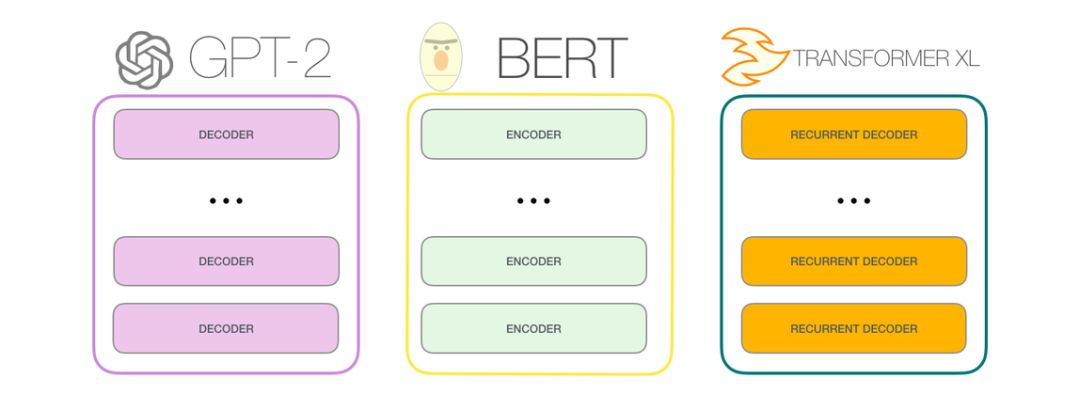

In [31]:
import subprocess
import os
# 设置环境变量, autodl一般区域
result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value
"""
import os

# 设置环境变量, autodl专区 其他idc
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# 打印环境变量以确认设置成功
print(os.environ.get('HF_ENDPOINT'))
"""

"\nimport os\n\n# 设置环境变量, autodl专区 其他idc\nos.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'\n\n# 打印环境变量以确认设置成功\nprint(os.environ.get('HF_ENDPOINT'))\n"

In [32]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast,AutoModelForMaskedLM

In [16]:
# 初始化一个空的 WordPiece 模型
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

In [ ]:
# 设置训练参数
trainer = WordPieceTrainer(
    vocab_size=30000,        # 词汇表大小
    min_frequency=2,         # 最小词频
    special_tokens=[
        "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"
    ]
)

tokenizer.train(files=["../01-data_env/data/dna_1g.txt"], trainer=trainer)

In [4]:
tokenizer.save("dna_wordpiece_dict.json")

## GPT2和bert配置的关键区别
* 最大长度：
在 GPT-2 中，n_ctx 参数指定了模型的最大上下文窗口大小。
在 BERT 中，你应该设置 max_position_embeddings 来指定最大位置嵌入数，这限制了输入序列的最大长度。
* 特殊 token ID：
GPT-2 使用 bos_token_id 和 eos_token_id 分别表示句子的开始和结束。
BERT 使用 [CLS] (cls_token_id) 表示句子的开始，用 [SEP] (sep_token_id) 表示句子的结束。BERT 还有专门的填充 token [PAD] (pad_token_id)。
* 模型类选择：
对于 GPT-2，你使用了 GPT2LMHeadModel，它适合生成任务或语言建模。
对于 BERT，如果你打算进行预训练（例如 Masked Language Modeling），应该使用 BertForMaskedLM。
* 预训练权重：
如果你想从头开始训练，像上面的例子中那样直接从配置创建模型即可。
如果你希望基于现有预训练模型微调，则可以使用 from_pretrained 方法加载预训练权重。

In [17]:
new_tokenizer = Tokenizer.from_file("dna_wordpiece_dict.json")

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=new_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
wrapped_tokenizer.save_pretrained("dna_wordpiece_dict")

('dna_wordpiece_dict/tokenizer_config.json',
 'dna_wordpiece_dict/special_tokens_map.json',
 'dna_wordpiece_dict/tokenizer.json')

In [33]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig,GPT2Tokenizer
from transformers import GPT2Tokenizer,GPT2Model,AutoModel
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import LineByLineTextDataset
from tokenizers import Tokenizer
from datasets import load_dataset
from transformers import BertConfig, BertModel

In [34]:
tokenizer = AutoTokenizer.from_pretrained("dna_wordpiece_dict")
#tokenizer.pad_token = tokenizer.eos_token

In [19]:
tokenizer("ATCGGATCG")

{'input_ids': [5, 761, 12283], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [35]:
tokenizer

PreTrainedTokenizerFast(name_or_path='dna_wordpiece_dict', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [36]:
from transformers import BertConfig,BertForMaskedLM

# 设置最大输入长度
max_length = 128  # 最大输入长度

# 构建配置
config = BertConfig(
    vocab_size=len(tokenizer),  # 词汇表大小，与分词器一致
    max_position_embeddings=max_length,  # 最大位置嵌入数，与 max_length 一致
    pad_token_id=tokenizer.pad_token_id,  # 填充标记的 ID
    bos_token_id=tokenizer.cls_token_id,  # 句子开始标记的 ID（BERT 使用 [CLS]）
    eos_token_id=tokenizer.sep_token_id,  # 句子结束标记的 ID（BERT 使用 [SEP]）
)

# Building the model from the config
model = BertForMaskedLM(config)

In [37]:
# 1. load dna dataset
raw_dataset = load_dataset('text',  data_files="../01-data_env/data/dna_1g.txt")
#dataset = raw_dataset["train"].select(range(1000)).train_test_split(test_size=0.1, shuffle=True)
dataset = raw_dataset["train"].train_test_split(test_size=0.1, shuffle=True)

# 2. tokenize
# def tokenize_function(examples):
#     return tokenizer(examples['text'][:100], truncation=True, padding='max_length', max_length=max_length)

# 2. tokenize, 必须设置最大长度
#默认是100，设置成1000就行了。否则如果字符串长超过100，就是有bug，只生成1个unk了
tokenizer._tokenizer.model.max_input_chars_per_word = 10000
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=max_length)


# 3. 对数据集应用分词函数
tokenized_datasets = dataset.map(tokenize_function, batched=False, remove_columns=['text'], num_proc=15)  # 设置为你的 CPU 核心数或根据需要调整

# 4. 创建一个数据收集器，用于动态填充和遮蔽,注意mlm=true
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True,mlm_probability=0.15
)

In [38]:
dataset["train"][0]

{'text': 'GAATCATATTTCTCTTAGTAATGCTTTCTATTCAAAATATTAAATGGAAATTTTAAAAAGAATTTTAGAGCTAATTCTAAACAATCTCTTTTACATTCATTCAACTGCCATTTTACTTTTCTGAAGTTGCTACCTTATTTTCTCTACCAAATATCATTATTTTAATTCATTGATTACATACACAGCTAGTTCTAAAGTTAAAAAAAGTACTTACTAAGCACTTATTAAACAATAAAATATGTTATTCACATTTGAAGCATAAGTAACCAATAAGTAACCAATTGTAACCAATGGTTACGTTAGCATAAATAGGATAAATATTTTAATGTATTAGCATTAGTTTTCTGATAGCACCCTGATCTGCTTGCACAAGAACCCAGGGACGGTTTTACTAGTACGCCAAATAAGCTGCAGCCAAGGGCTCTTATAATATTTAGAGGAACCTATTTTAAAACATGGAACTTTTTTCTTTAAAGTTCTATAAAATTTGATTATTTATGAGTGATAAAGGCCTTAAAAATTTATTCTGCTTTGGCTCCCTGAAATGTTACAAATGTTTTAGGTACTAAAGTGTTATTTATATGAATGCCATATACACTCATAAATTATAACTAAGATTGACTAAATAGCTAATGAATTCCCACAATTTGCCATAAAACATTAACCGGCTTGCCTTACCGTACCAAGTTTAAACTATTTAAAGTTAAAAATTTGGCTTGGGCTAAAGTCACCCTTAGTGCCAAAGTATTATTAATGTGAATCAGCATTTTTTGTTTTGAATCGAATCTTGAATTATAGCAGGTCCTGATTCGCGTTTAAATCATATTTCAAATCAATGTTTTTAAGTCTAAATTTAAGCTTTTTTTGTCTTGTTTTTTTGTCCTGTTTTTTTTTGTCCTGTTTTTGGCCCTGTGAATCAGCATTTTTTGTTTTGAATCGAATCTTGAATCGAAGTAGGTCTTGATTCGCGTTTTTAATCACATTTCAAAT

In [24]:
tokenizer.tokenize(dataset["train"][0]["text"][:100])

['GAA',
 '##TCATATT',
 '##TCTCTTA',
 '##GTAATG',
 '##CTTTCTATT',
 '##CAAAATATTA',
 '##AA',
 '##TGGAA',
 '##A',
 '##TTTTAAAAA',
 '##GAATTTTA',
 '##GAGCTAA',
 '##TT',
 '##CTAAACAA',
 '##TCTCTTTTA',
 '##CATT',
 '##CAT']

In [39]:
run_path = "bert_run"
train_epoches = 200
batch_size = 10


training_args = TrainingArguments(
        output_dir=run_path,
        overwrite_output_dir=True,
        num_train_epochs=train_epoches,
        per_device_train_batch_size=batch_size,
        save_steps=2000,
        save_total_limit=2,
        prediction_loss_only=True,
        fp16=True, #v100没法用
    )


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
)

In [26]:
trainer.train()
trainer.save_model("dna_bert_v0")

Step,Training Loss
500,9.029000
1000,8.534200
1500,8.344000
2000,8.243700
2500,8.190700
3000,8.172000
3500,8.167900
4000,8.123100
4500,8.081900
5000,8.115100


In [28]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 145488.27


In [29]:
#upload model
#model.push_to_hub("dna_bert_v0", organization="dnagpt", use_auth_token="hf_*******")

In [30]:
from transformers import AutoTokenizer, AutoModel
import torch
model = AutoModel.from_pretrained('dna_bert_v0')
model

Some weights of BertModel were not initialized from the model checkpoint at dna_bert_v0 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30000, 768, padding_idx=0)
    (position_embeddings): Embedding(128, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False